In [76]:
######################
#import useful modules
######################

import sys

sys.path.append("/home/gula/Desktop/Work_capella/Python/Python_Modules_p3/") 

from Modules import *
from Modules_gula import *

from matplotlib.offsetbox import AnchoredText
import matplotlib.colors as colors
########

%matplotlib inline

########

import scipy.io as io
import functools
from scipy.interpolate import interp1d


In [77]:
####

adcp='75'; matfile = 'Data/soup_vorticity_os75bb_fit.mat'; zbin_75 = [0,50,90,150,200,255] #,300,400,600]
SM_75 = io.loadmat(matfile)
z75 = SM_75['z']

####

adcp=300; matfile = 'Data/soup_vorticity_wh300_assisted.mat'; zbin_300 = [0,50,90]
SM_300 = io.loadmat(matfile)
z300 = SM_300['z']

####


print(z300)
print(z75[:10])
      

[[21.16813917]
 [29.16813917]
 [37.16813872]
 [45.16813872]
 [53.16813872]
 [61.16813872]
 [69.16813979]
 [77.16813979]
 [85.16813979]]
[[21.49846892]
 [29.49846892]
 [37.49846859]
 [45.49846859]
 [53.49846859]
 [61.49846859]
 [69.49846862]
 [77.49846862]
 [85.49846862]
 [93.49846862]]


In [78]:


def dist(lon,lat):
    lon = np.double(lon*2*np.pi/360.)
    lat = np.double(lat*2*np.pi/360.)
    dx = np.arccos(np.sin(lat[1:])*np.sin(lat[:-1]) +\
                   np.cos(lat[1:])*np.cos(lat[:-1])*np.cos(lon[1:]-lon[:-1]))*6371000.
    dy = np.arccos(np.sin(lat[1:])*np.sin(lat[:-1]) +\
                   np.cos(lat[1:])*np.cos(lat[:-1])*np.cos(lon[1:]-lon[:-1]))*6371000.        
    return np.concatenate(([0],np.cumsum(np.sqrt(dx**2+dy**2))))

#########

def load_data(SM):

    f = 8.7e-5
    
    z = SM['z']
    LL = SM['LL']
    lon = np.real(LL)[0,:]
    lat = np.imag(LL)[0,:]

    x = dist(lon,lat)/1000.

    ######
    
    UVx = SM['UVx']
    UVy = SM['UVy']

    Ux = np.real(UVx)
    Vx = np.imag(UVx)
    Uy = np.real(UVy)
    Vy = np.imag(UVy)

    Sn = Ux-Vy; # stretch
    Sx = Vx+Uy; # shear

    strain = np.sqrt(Sn**2 + Sx**2)/f # strain
    div = (Ux+Vy)/f # divergence 
    vrt = (Vx-Uy)/f # vorticity

    ######
    # density
    
    Rx = SM['Rx']
    Ry = SM['Ry']
    R0 = SM['R0']
    z_ctd = SM['z_ctd']

    N2 = np.copy(Rx) * np.nan
    N2[1:,:] =np.sqrt( -(R0[1:,:] - R0[:-1,:] ) / (z_ctd[1:] - z_ctd[:-1]) * (-9.81/1027.5) )
    N2[0,:] = N2[1,:]
    
    ######

    bx = Rx * (-9.81/1027.5)
    by = Ry * (-9.81/1027.5)

    dxbuoy2 = 0.5 * (bx**2 + by**2)

    M = dxbuoy2 / N2

    tend = -1*(bx * Ux[:bx.shape[0],:] * bx + by * Uy[:bx.shape[0],:] * bx\
               + bx * Vx[:bx.shape[0],:] * by + by * Vy[:bx.shape[0],:] * by)

    
    ######
    
    return x,z,vrt,div,strain,z_ctd,dxbuoy2,tend,R0,M
    

In [80]:


x_75, z_75, vrt_75, div_75, strain_75, z_ctd_75, dxbuoy2_75, tend_75, R0_75, M_75  = load_data(SM_75)

x_300,z_300,vrt_300,div_300,strain_300,z_ctd_300,dxbuoy2_300,tend_300,R0_300,M_300 = load_data(SM_300)



/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt


In [81]:
SM_75['xy']

array([[ 144.04934495+112.07509851j,  143.88494504+111.96120099j,
         143.72175915+111.84557766j, ..., -115.40451251 +64.70933796j,
        -115.55605935 +64.83985057j, -115.7075248  +64.97045745j]])

In [82]:
x_75

array([0.00000000e+00, 2.80046739e-01, 5.60140171e-01, ...,
       6.85889873e+02, 6.86171339e+02, 6.86452805e+02])

/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in sqrt
/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:17: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipyker

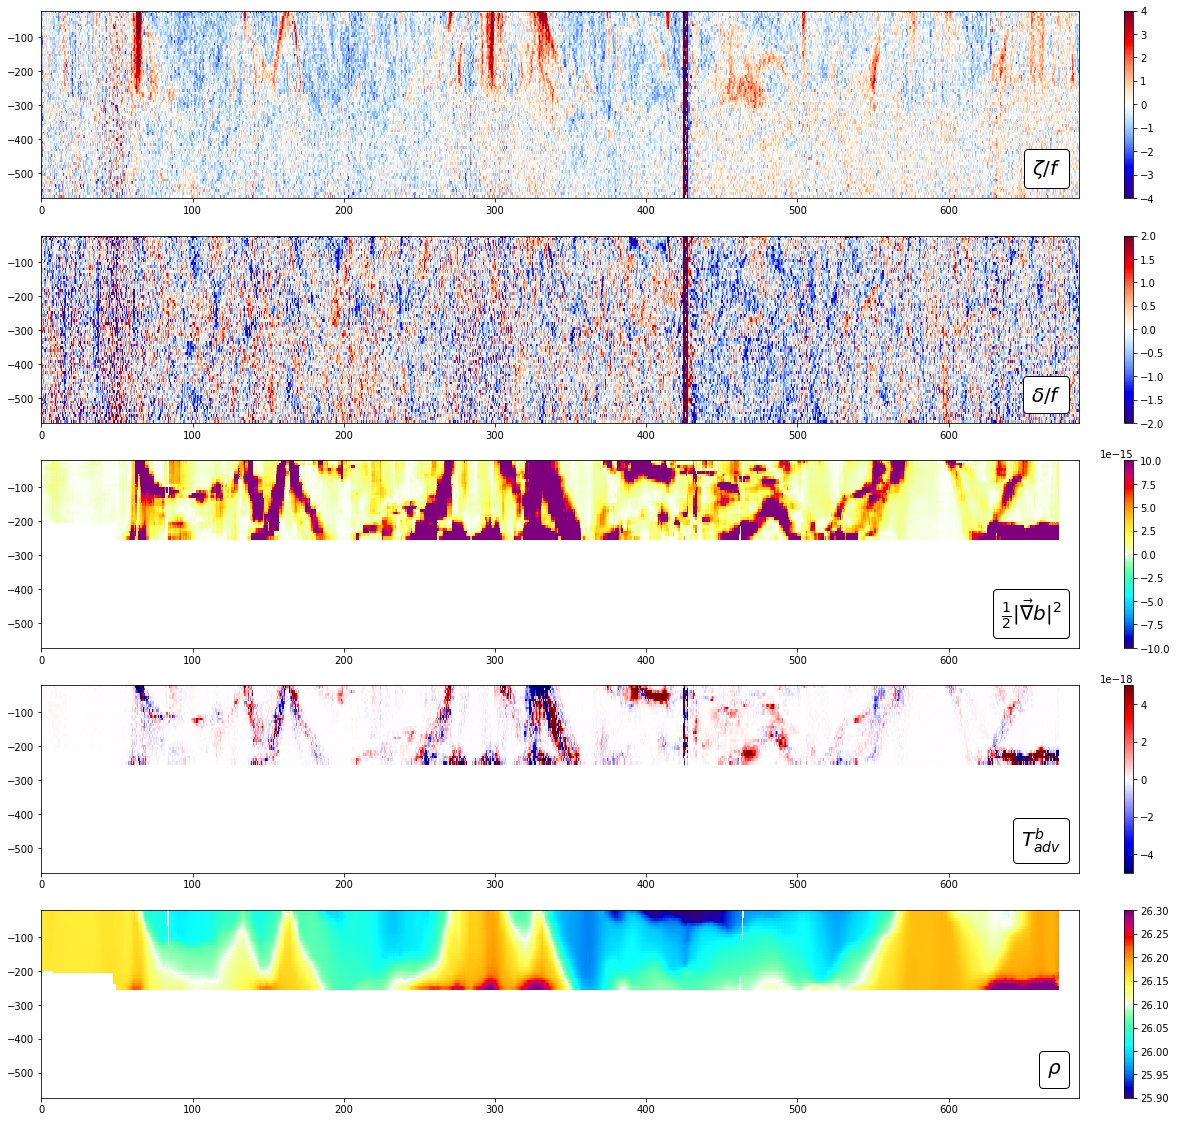

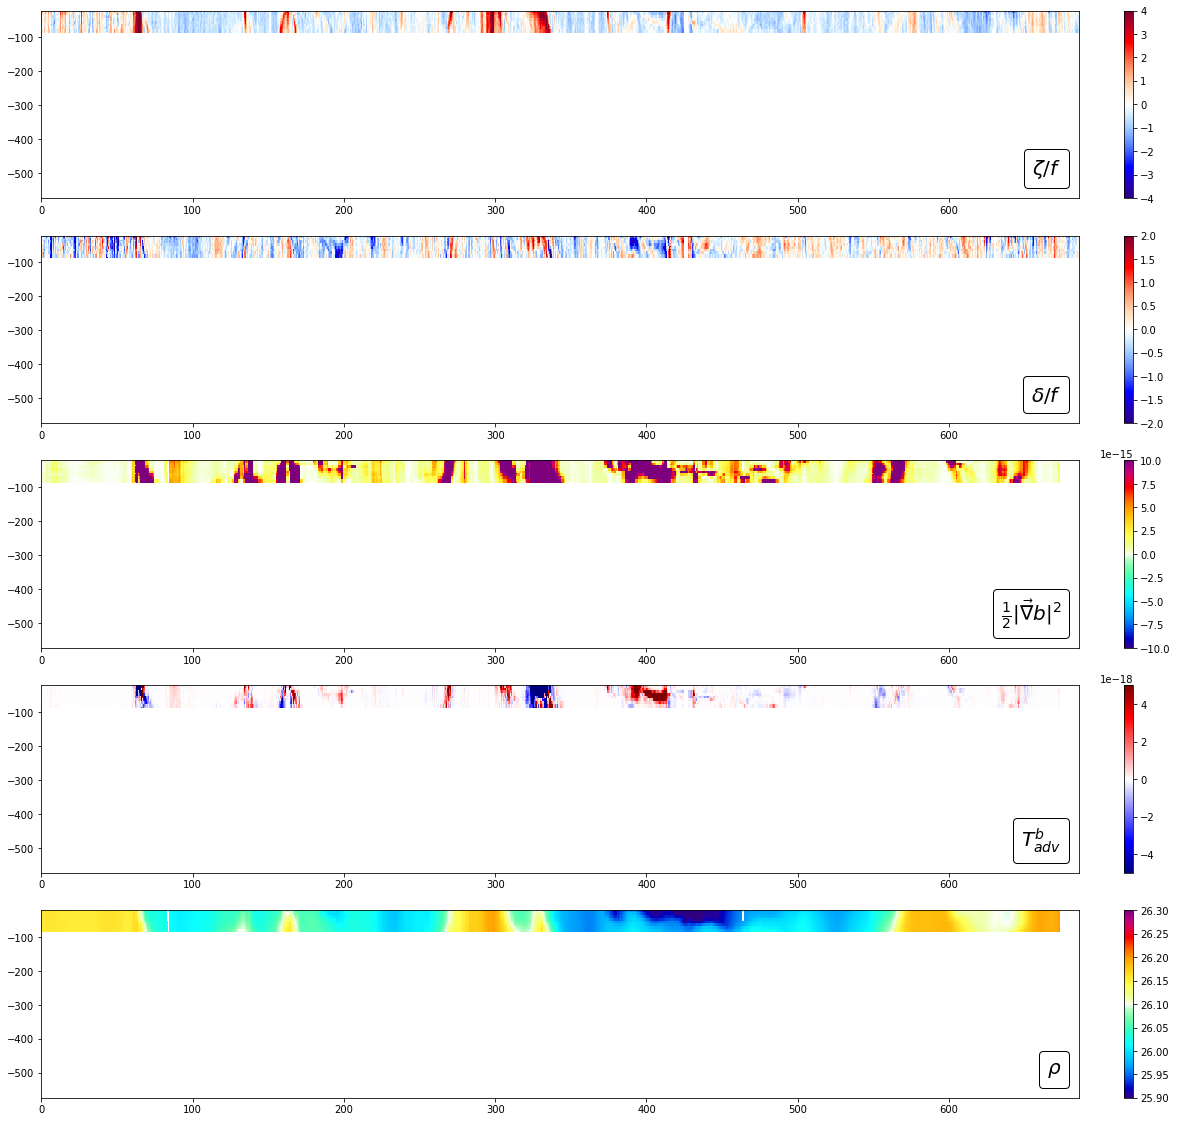

In [103]:
name=['75','300']

####


for i,SM in enumerate([SM_75,SM_300]):


    x,z,vrt,div,strain,z_ctd,dxbuoy2,tend,R0,M = load_data(SM)


    f,axes = plt.subplots(5,1,figsize=(20,20)) #,facecolor='Gainsboro') #, constrained_layout=True)

    #########

    CS0 = axes[0].pcolormesh(x,-z,vrt,vmin=-4,vmax=4,\
                       cmap =plot.ncview_colormap('blu_red') ); 
    f.colorbar(CS0, ax = axes[0],fraction=0.03, pad=0.04)
    axes[0].set_ylim([min(-z75),max(-z75)])
    at = AnchoredText(r'$\zeta/f$',loc=4, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axes[0].add_artist(at)

    #########

    CS1 = axes[1].pcolormesh(x,-z,div,vmin=-2,vmax=2,\
                       cmap =plot.ncview_colormap('blu_red') ); 
    f.colorbar(CS1, ax = axes[1],fraction=0.03, pad=0.04)
    axes[1].set_ylim([min(-z75),max(-z75)])
    at = AnchoredText(r'$\delta/f$',loc=4, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axes[1].add_artist(at)

    #########

    CS2 = axes[2].pcolormesh(x,-z_ctd,dxbuoy2,vmin=-1e-14,vmax=1e-14,\
                       cmap =plot.ncview_colormap('jaisnd') ); 
    f.colorbar(CS2, ax = axes[2],fraction=0.03, pad=0.04)
    axes[2].set_ylim([min(-z75),max(-z75)])
    at = AnchoredText(r'$\frac{1}{2} \| \vec{\nabla} b \|^2 $',loc=4, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axes[2].add_artist(at)

    #########

    CS3 = axes[3].pcolormesh(x,-z_ctd,tend,\
                       cmap =plot.ncview_colormap('blue_red'),\
                              vmin=-5e-18,vmax=5e-18 ); 
    f.colorbar(CS3, ax = axes[3],fraction=0.03, pad=0.04)
    axes[3].set_ylim([min(-z75),max(-z75)])
    at = AnchoredText(r'$T^b_{adv}$',loc=4, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axes[3].add_artist(at)

    #########

    CS4 = axes[4].pcolormesh(x,-z_ctd,R0,\
                       cmap =plot.ncview_colormap('jaisnd'),\
                             vmin=25.9,vmax=26.3 ); 
    f.colorbar(CS4, ax = axes[4],fraction=0.03, pad=0.04)
    axes[4].set_ylim([min(-z75),max(-z75)])
    at = AnchoredText(r'$\rho$',loc=4, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axes[4].add_artist(at)



    plt.savefig('section_latmix_' + name[i] + 'kHz.png',bbox_inches='tight', transparent='true', dpi=200)


    
del x,z,vrt,div,strain,z_ctd,dxbuoy2,tend,R0,M

In [41]:
print(vrt_75.shape);print(vrt_300.shape)


lon_75 = np.real(SM_75['LL'])[0,:]
lat_75 = np.imag(SM_75['LL'])[0,:]

lon_300 = np.real(SM_300['LL'])[0,:]
lat_300 = np.imag(SM_300['LL'])[0,:]


print(lon_75[:-1]-lon_300)
print(lat_75[:-1]-lat_300)

(70, 2430)
(9, 2429)
[-0.00041136 -0.00041029 -0.0004017  ... -0.00028136 -0.00028679
 -0.0002885 ]
[-0.00021176 -0.000213   -0.00022278 ...  0.00019729  0.00019225
  0.00019066]


In [71]:
x_75[1:]-x_75[:-1]

array([0.28004674, 0.28009343, 0.28011917, ..., 0.2814727 , 0.28146649,
       0.28146592])

In [84]:
import scipy.stats as st





def simple_pdf(axe, vrt1,vrt2,label=' ',label_ax1=r'$\zeta/f$ [75kHz]',label_ax2=r'$\zeta/f$ [300kHz]',\
               varname='count',cond=True,cmap = 'blu_red', levels=np.linspace(-1e-2,1e-2,100)):
    
    
    ###################

    my_cmap=plot.ncview_colormap(cmap); 
    
    ###################

    xlim_ref = 4; bins_ = np.linspace(-xlim_ref,xlim_ref,50)
    sample_points_identity = np.arange(-10,10,0.1)

    ##########
    #,axe = plt.subplots(1,1,figsize=(7,6)) #,facecolor='Gainsboro') #, constrained_layout=True)

    axe.plot(sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
    axe.plot(-sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
    
    axe.set_xlim((-1.*xlim_ref,1.*xlim_ref)) ;
    axe.set_ylim((-1.*xlim_ref,1.*xlim_ref)) ; axe.set_aspect('equal')
    
    axe.set_ylabel(label_ax2,fontsize=16); axe.set_xlabel(label_ax1,fontsize=16); 
        
    ####################
    ## Density of particles
    d_vrt_strain, xedges, yedges,_ = st.binned_statistic_2d(vrt1[cond].ravel(),vrt2[cond].ravel(),\
                                                            values=None,statistic='count', bins = bins_)
    
    # Plot 2D histogram using pcolormesh
    im = axe.pcolormesh(xedges,yedges,ma.masked_invalid(d_vrt_strain.T),\
                            cmap='Reds',norm=colors.SymLogNorm(linthresh=0.01,base=10,vmin=1,vmax=50))
    
    plt.colorbar(im, ax = axe,fraction=0.03, pad=0.04)
    axe.set_title('# of grid points',fontsize=18)
    
    ####################
    
    # add label
    at = AnchoredText(label,loc=2, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axe.add_artist(at)
    

    


/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:17: RuntimeWarning: Mean of empty slice
/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:19: RuntimeWarning: Mean of empty slice


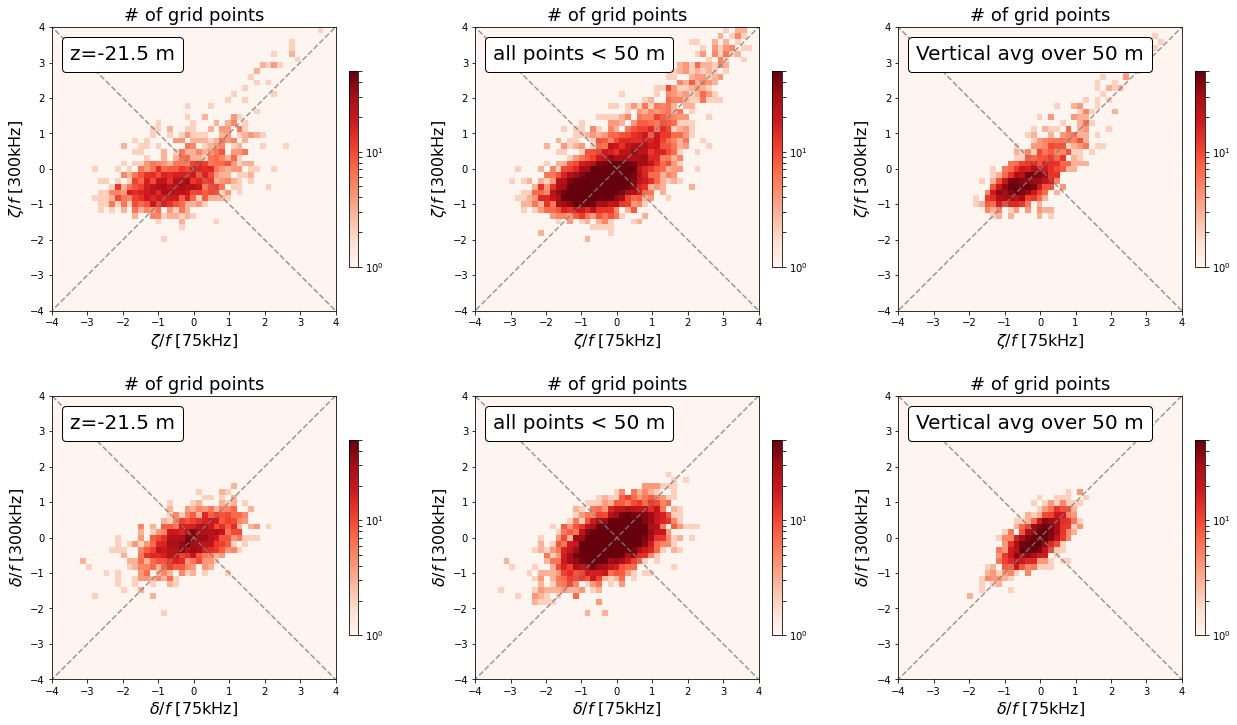

In [115]:
# Comparison
f,axes = plt.subplots(2,3,figsize=(21,12))


i= 0; label = 'z='+format(np.round(-z_75[i][0],1))+' m'
simple_pdf(axes[0,0],vrt_75[i,:-1] ,vrt_300[i,:], label = label)
simple_pdf(axes[1,0],div_75[i,:-1] ,div_300[i,:], label_ax1=r'$\delta/f$ [75kHz]',label_ax2=r'$\delta/f$ [300kHz]', label = label)


i1= 0; i2=4; label = 'all points < 50 m'
simple_pdf(axes[0,1],vrt_75[i1:i2,:-1] ,vrt_300[i1:i2,:], label = label)
simple_pdf(axes[1,1],div_75[i1:i2,:-1] ,div_300[i1:i2,:],\
           label_ax1=r'$\delta/f$ [75kHz]',label_ax2=r'$\delta/f$ [300kHz]', label = label)


i1= 0; i2=4; label = 'Vertical avg over 50 m'
simple_pdf(axes[0,2],np.nanmean(vrt_75[i1:i2,:-1],axis=0) ,np.nanmean(vrt_300[i1:i2,:],axis=0), label = label)

simple_pdf(axes[1,2],np.nanmean(div_75[i1:i2,:-1],axis=0) ,np.nanmean(div_300[i1:i2,:],axis=0),\
           label_ax1=r'$\delta/f$ [75kHz]',label_ax2=r'$\delta/f$ [300kHz]', label = label)

plt.subplots_adjust(wspace=0.3,hspace=0.3)

plt.savefig('adcp_comparison.png')


0.7367000623707594 0.512402886159957
-0.09867973123067425 -0.054725427217196906
0.5559148899866926 0.477582611692932


/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:38: RuntimeWarning: Mean of empty slice
/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: Mean of empty slice


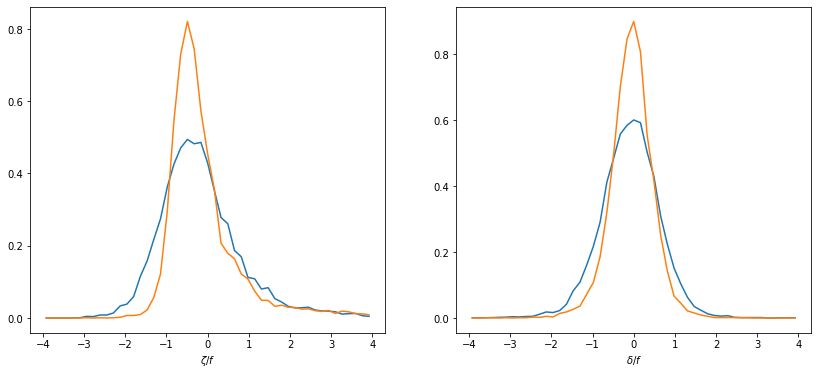

In [145]:
# 6. define a function to compute a pdf
def mypdf(u,bins):
    pdf, _ = np.histogram(u,bins)
    pdf = pdf / ((bins[2]-bins[1])*len(u.ravel()))
    return pdf

############

div_75[np.abs(div_75[:,:])>10] = np.nan
vrt_75[np.abs(div_75[:,:])>10] = np.nan
div_300[np.abs(div_300[:,:])>10] = np.nan
vrt_300[np.abs(div_300[:,:])>10] = np.nan

############

xlim_ref = 4; bins_ = np.linspace(-xlim_ref,xlim_ref,50)

# Comparison
f,axes = plt.subplots(1,2,figsize=(14,6))

i1= 0; i2=4; label = 'all points < 50 m'

pdf = mypdf(vrt_75[i1:i2,:-1],bins_)
axes[0].plot(0.5*(bins_[:-1]+bins_[1:]),pdf,'-');
pdf = mypdf(vrt_300[i1:i2,:],bins_)
axes[0].plot(0.5*(bins_[:-1]+bins_[1:]),pdf,'-');
axes[0].set_xlabel(r'$\zeta/f$')

pdf = mypdf(div_75[i1:i2,:-1],bins_)
axes[1].plot(0.5*(bins_[:-1]+bins_[1:]),pdf,'-');
pdf = mypdf(div_300[i1:i2,:],bins_)
axes[1].plot(0.5*(bins_[:-1]+bins_[1:]),pdf,'-');
axes[1].set_xlabel(r'$\delta/f$')

print(np.nanstd(div_75[i1:i2,:-1]), np.nanstd(div_300[i1:i2,:-1]))


print(np.nanmean(np.nanmean(div_75[i1:i2,:-1],axis=0)), np.nanmean(np.nanmean(div_300[i1:i2,:-1],axis=0)))
print(np.nanstd(np.nanmean(div_75[i1:i2,:-1],axis=0)), np.nanstd(np.nanmean(div_300[i1:i2,:-1],axis=0)))



In [144]:
bins_[2]-bins_[1]

0.16326530612244872

In [89]:
z_300

array([[21.16813917],
       [29.16813917],
       [37.16813872],
       [45.16813872],
       [53.16813872],
       [61.16813872],
       [69.16813979],
       [77.16813979],
       [85.16813979]])

In [44]:

def concatenate_data(zbin,z, vrt):


    # Append data in vertical Bins
    vrt_avg = {}
    vrt_bin = {}
    vrt_bin_surf = {}

    # init
    for ibin,my_bin in enumerate(zbin[1:]):
        vrt_bin[ibin] = []
        vrt_bin_surf[ibin] = []  

    # appd data
    for iz,my_z in enumerate(z):
        for ibin,my_bin in enumerate(zbin[1:]):
            if my_z < my_bin:
                vrt_bin[ibin] = np.concatenate((vrt_bin[ibin],vrt[iz,:]))
                vrt_bin_surf[ibin] = np.concatenate((vrt_bin_surf[ibin],np.mean(vrt[:4,:],axis=0)))
                #print('OK for ', format(my_z), ' in ', format(my_bin))
                break

    
    for ibin,my_bin in enumerate(zbin[1:]):
        
        vrt_avg[ibin] = np.nanmean(vrt[np.logical_and(zbin[ibin+1]<z[:,0],z[:,0]<my_bin),:],axis=0) 

    
    return vrt_bin, vrt_bin_surf, vrt_avg


In [47]:


vrt_bin_75,vrt_bin_surf_75, vrt_avg_75 = concatenate_data(zbin_75,z_75, vrt_75)
div_bin_75,div_bin_surf_75, div_avg_75 = concatenate_data(zbin_75,z_75, div_75)
strain_bin_75,strain_bin_surf_75, strain_avg_75 = concatenate_data(zbin_75,z_75, strain_75)
dxbuoy2_bin_75,dxbuoy2_bin_surf_75, dxbuoy2_avg_75 = concatenate_data(zbin_75,z_ctd_75, dxbuoy2_75)
tend_bin_75,tend_bin_surf_75, tend_avg_75 = concatenate_data(zbin_75,z_ctd_75, tend_75)
M_bin_75,M_bin_surf_75, M_avg_75 = concatenate_data(zbin_75,z_ctd_75, M_75)

vrt_bin_300,vrt_bin_surf_300, vrt_avg_300 = concatenate_data(zbin_300,z_300, vrt_300)
div_bin_300,div_bin_surf_300, div_avg_300 = concatenate_data(zbin_300,z_300, div_300)
strain_bin_300,strain_bin_surf_300, strain_avg_300 = concatenate_data(zbin_300,z_300, strain_300)
dxbuoy2_bin_300,dxbuoy2_bin_surf_300, dxbuoy2_avg_300 = concatenate_data(zbin_300,z_ctd_300, dxbuoy2_300)
tend_bin_300,tend_bin_surf_300, tend_avg_300 = concatenate_data(zbin_300,z_ctd_300, tend_300)
M_bin_300,M_bin_surf_300, M_avg_300 = concatenate_data(zbin_300,z_ctd_300, M_300)





/home/gula/.virtualenvs/croco36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: Mean of empty slice


In [189]:


def jpdf(vrt,strain,w,label,data='adcp300', vrtsfc=None,strainsfc=None,varname='div',cond=True,\
         cmap = 'blu_red', levels=np.linspace(-1e-2,1e-2,100),symstrain=True,surf=True):
    
    
    ###################

    my_cmap=plot.ncview_colormap(cmap); 
    
    if varname=='div':
        varlabel = 'Divergence [10$^{-2}$]'
    elif varname=='dxbuoy2':
        varlabel=r'$\frac{1}{2} \| \vec{\nabla} b \|^2 $'    
    elif varname=='M':
        varlabel=r'$\frac{1}{2} \| \vec{\nabla} b \|^2 / N^2$'    
    elif varname=='tendency':
        varlabel = '$T^b_{adv}$' 
    else:
        varlabel = 'Vertical velocity' 
    
    ###################
    
    if vrtsfc is None: vrtsfc=vrt
    if strainsfc is None: strsfc=strain

    xlim_ref = 5; bins_ = np.linspace(-xlim_ref,xlim_ref,50)
            
    if symstrain: 
        sample_points_identity = np.arange(0,10,0.1)
    else:
        sample_points_identity = np.arange(-10,10,0.1)

    ##########
    f,axes = plt.subplots(1,3,figsize=(20,6)) #,facecolor='Gainsboro') #, constrained_layout=True)

    for axe in axes:
        axe.plot(sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
        axe.plot(-sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
        axe.set_xlim((-1*xlim_ref,1.*xlim_ref)) ; 
        
        if symstrain: 
            axe.set_ylim((0,1.*xlim_ref)) ; axe.set_aspect('equal')
            axe.set_ylabel(r'$\sigma/|f|$',fontsize=16)
        else:
            axe.set_ylim((-1.*xlim_ref,1.*xlim_ref)) ; axe.set_aspect('equal')
            axe.set_ylabel(r'$\delta/|f|$',fontsize=16)

        axe.set_xlabel(r'$\zeta/f$',fontsize=16); 

        
    ####################
    ## Density of particles
    d_vrt_strain, xedges, yedges,_ = st.binned_statistic_2d(vrt[cond].ravel(),strain[cond].ravel(),\
                                                            values=None,statistic='count', bins = bins_)
    
    # Plot 2D histogram using pcolormesh
    im = axes[0].pcolormesh(xedges,yedges,ma.masked_invalid(d_vrt_strain.T),\
                            cmap='Blues',norm=colors.SymLogNorm(linthresh=0.01,base=10,vmin=1,vmax=100))
    f.colorbar(im, ax = axes[0],fraction=0.03, pad=0.04)
    axes[0].set_title('# of grid points',fontsize=18)
    
    
    ####################
    ## vertical velocity
    w_vrt_strain, xedges, yedges,_ = st.binned_statistic_2d(vrt[cond].ravel(),strain[cond].ravel(),values=w[cond].ravel(),\
                                                        statistic='mean', bins = bins_)
    w_vrt_strain[d_vrt_strain<1] = np.nan # Replace values where the JPDF is really low (i.e. ery unlikely points) by nan
    # so that they do not pollute the figure !

    # Plot 2D histogram using pcolormesh
    im = axes[1].pcolormesh(xedges,yedges,ma.masked_invalid(w_vrt_strain.T),cmap=my_cmap,\
                            norm=colors.SymLogNorm(linthresh=levels.max()/100,base=10,vmin=levels.min(),vmax=levels.max()))
    f.colorbar(im, ax = axes[1],fraction=0.03, pad=0.04)

        
    axes[1].set_title(varlabel,fontsize=18)
    
    if surf:
        ####################
        ## vertical velocity 
        w_vrt_strain, xedges, yedges,_ = st.binned_statistic_2d(vrtsfc[cond].ravel(),strainsfc[cond].ravel(),values=w[cond].ravel(),\
                                                            statistic='mean', bins = bins_)
        #w_vrt_strain[d_vrt_strain<1] = np.nan # Replace values where the JPDF is really low (i.e. ery unlikely points) by nan
        # so that they do not pollute the figure !

        axes[2].set_xlabel(r'$\zeta/f$ (surface)',fontsize=16); axes[2].set_ylabel(r'$\sigma/|f|$ (surface)',fontsize=16)

        # Plot 2D histogram using pcolormesh
        im = axes[2].pcolormesh(xedges,yedges,ma.masked_invalid(w_vrt_strain.T),cmap=my_cmap,\
                                norm=colors.SymLogNorm(linthresh=levels.max()/100,base=10,vmin=levels.min(),vmax=levels.max()))
        f.colorbar(im, ax = axes[2],fraction=0.03, pad=0.04)



        axes[2].set_title(varlabel,fontsize=18)
    
    # add label
    at = AnchoredText(label,loc=2, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axes[1].add_artist(at)
    
    plt.subplots_adjust(wspace=0.3)
    
    filename = data + '_' +  varname + '_z' +label 
    
    if not symstrain: filename = filename + '_sym'
    
    plt.savefig(filename + '.png' ,bbox_inches='tight', transparent='true', dpi=200)

    
###############################

# ADCP 75 KHz

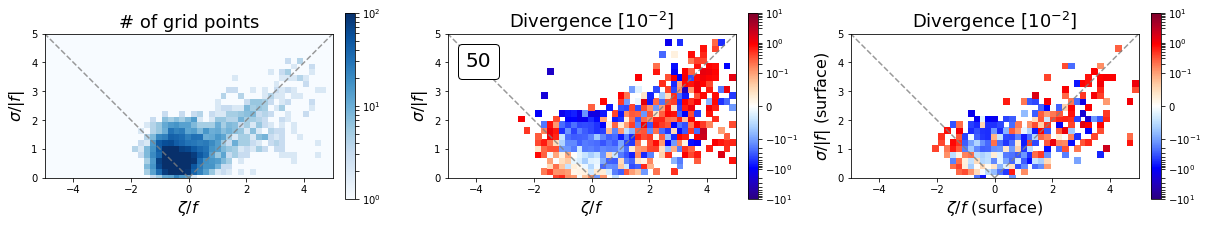

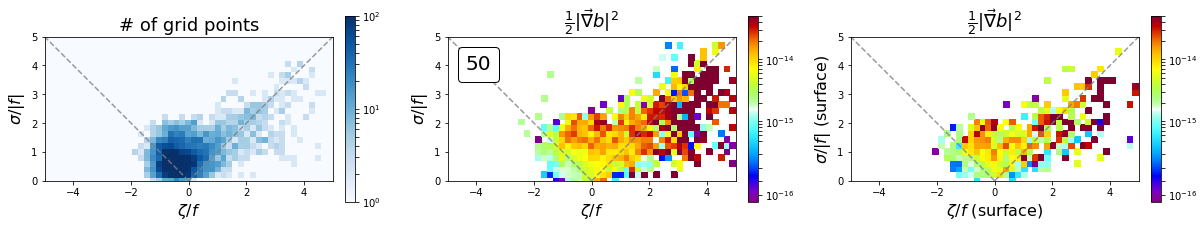

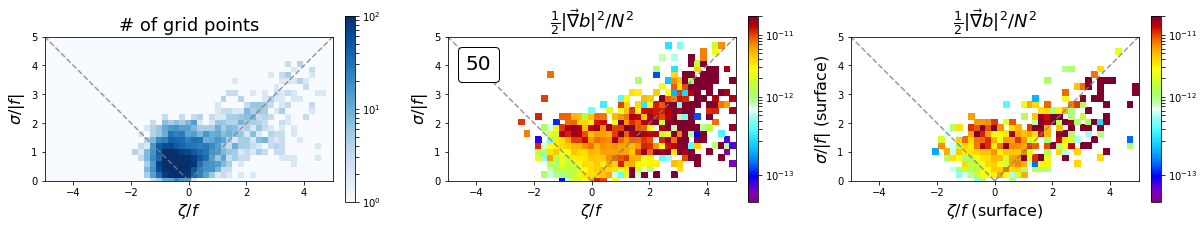

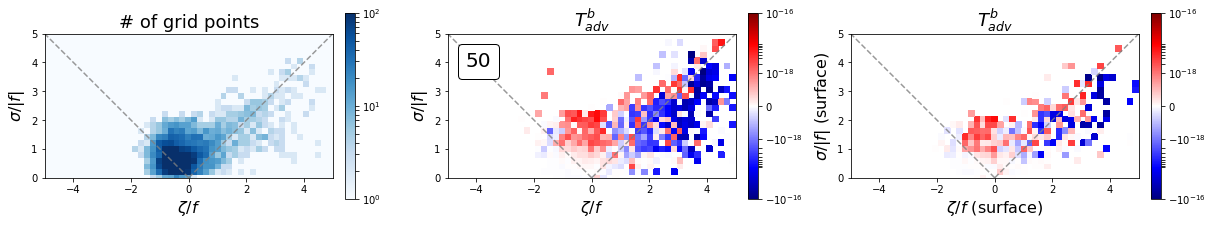

In [190]:



ibin=0;
data='adcp300bin'

cond = dxbuoy2_bin_surf_300[ibin]>1e-14 # only surface frontal regions
cond=np.isfinite(M_bin_300[ibin])

jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],div_bin_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin], levels=np.arange(-1.,1.02,0.02)*10.,\
         varname='div',cond= cond) #,cond=np.isfinite(dxbuoy2_bin_300[ibin]))

jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],dxbuoy2_bin_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin],varname='dxbuoy2', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*5e-14,cond= cond)

jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],M_bin_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin],varname='M', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*2e-11,cond= cond)

jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],tend_bin_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin],\
         varname='tendency',  cmap = 'blue_red', levels=np.arange(-1.,1.02,0.02)*1e-16,cond= cond)




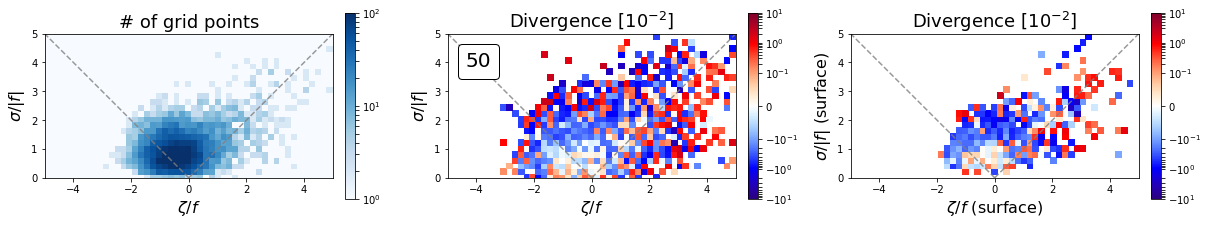

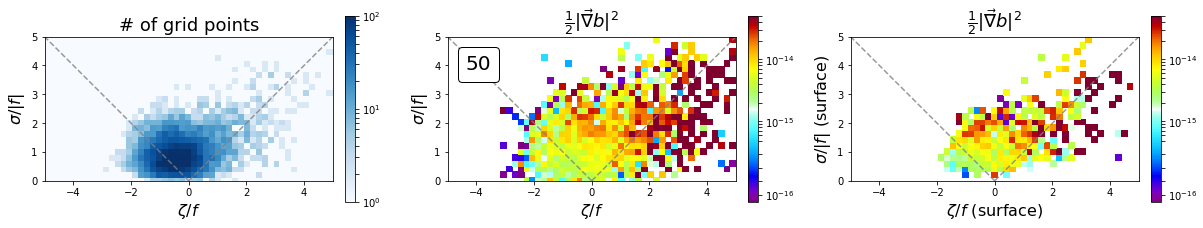

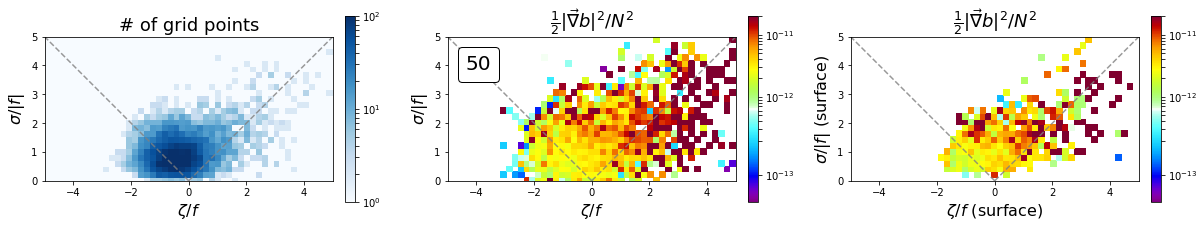

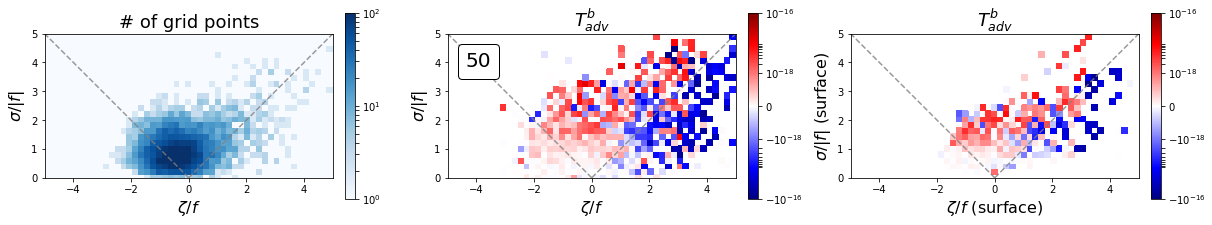

In [191]:



ibin=0;
data='adcp75bin'

cond = dxbuoy2_bin_surf_75[ibin]>1e-14 # only surface frontal regions
cond=np.isfinite(M_bin_75[ibin])

jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],div_bin_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin], levels=np.arange(-1.,1.02,0.02)*10.,\
         varname='div',cond= cond) #,cond=np.isfinite(dxbuoy2_bin_75[ibin]))

jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],dxbuoy2_bin_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin],varname='dxbuoy2', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*5e-14,cond= cond)

jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],M_bin_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin],varname='M', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*2e-11,cond= cond)

jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],tend_bin_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin],\
         varname='tendency',  cmap = 'blue_red', levels=np.arange(-1.,1.02,0.02)*1e-16,cond= cond)




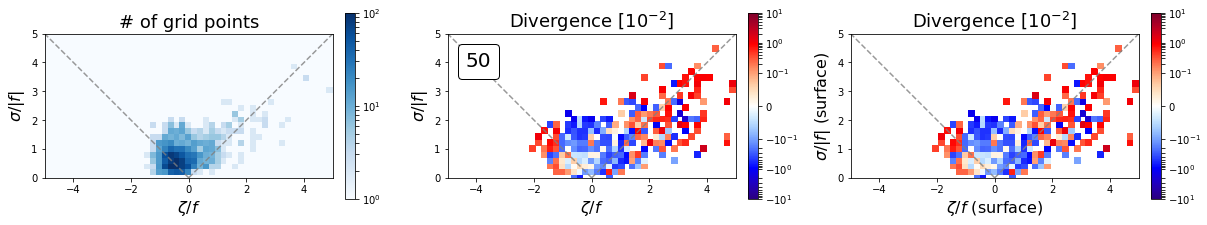

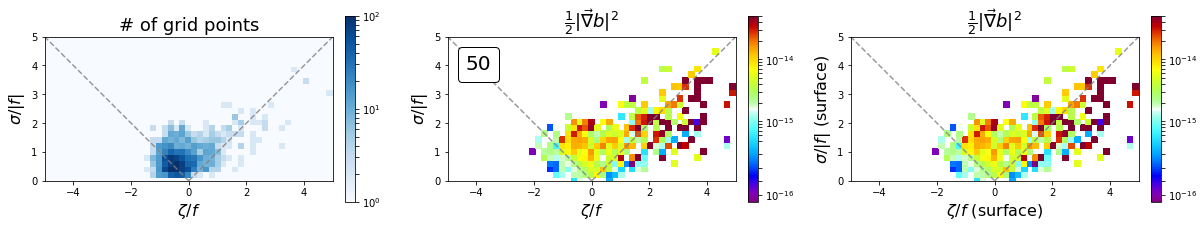

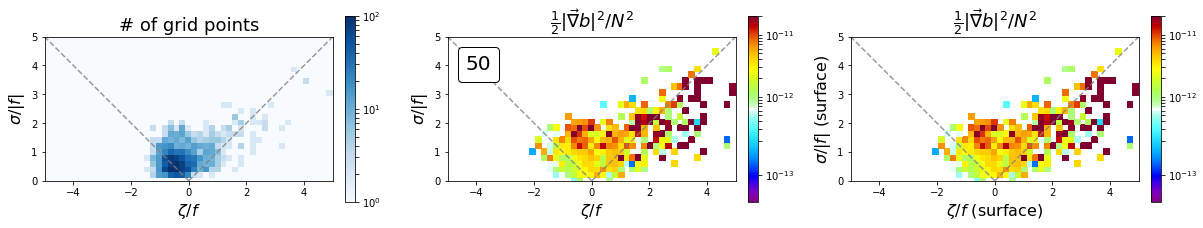

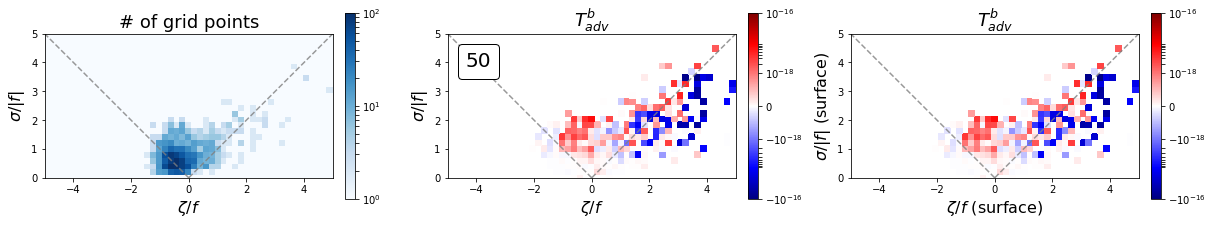

In [192]:
ibin=0;
data='adcp300avg'


cond = dxbuoy2_avg_300[ibin]>1e-14 # only surface frontal regions
cond=np.isfinite(M_avg_300[ibin])

jpdf(vrt_avg_300[ibin],strain_avg_300[ibin],div_avg_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_300[0],strainsfc=strain_avg_300[0], levels=np.arange(-1.,1.02,0.02)*10.,\
         varname='div',cond= cond) #,cond=np.isfinite(dxbuoy2_avg_300[ibin]))

jpdf(vrt_avg_300[ibin],strain_avg_300[ibin],dxbuoy2_avg_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_300[0],strainsfc=strain_avg_300[0],varname='dxbuoy2', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*5e-14,cond= cond)

jpdf(vrt_avg_300[ibin],strain_avg_300[ibin],M_avg_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_300[0],strainsfc=strain_avg_300[0],varname='M', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*2e-11,cond= cond)

jpdf(vrt_avg_300[ibin],strain_avg_300[ibin],tend_avg_300[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_300[0],strainsfc=strain_avg_300[0],\
         varname='tendency',  cmap = 'blue_red', levels=np.arange(-1.,1.02,0.02)*1e-16,cond= cond)

###

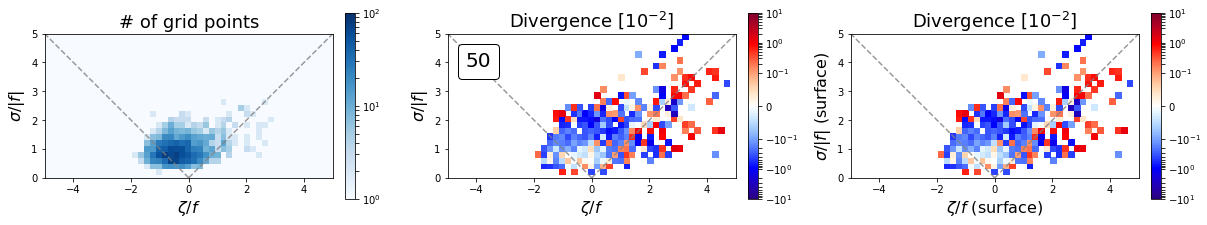

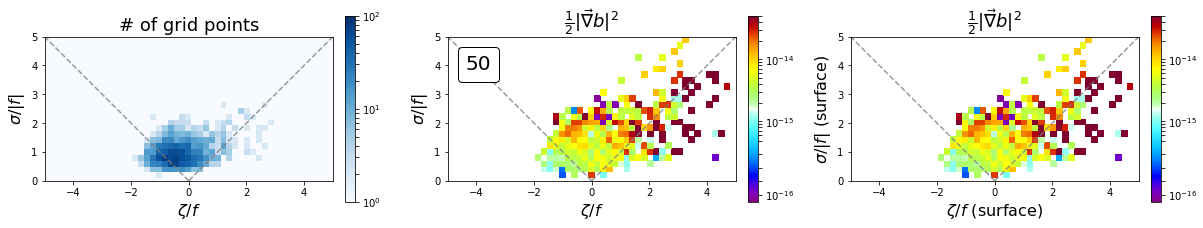

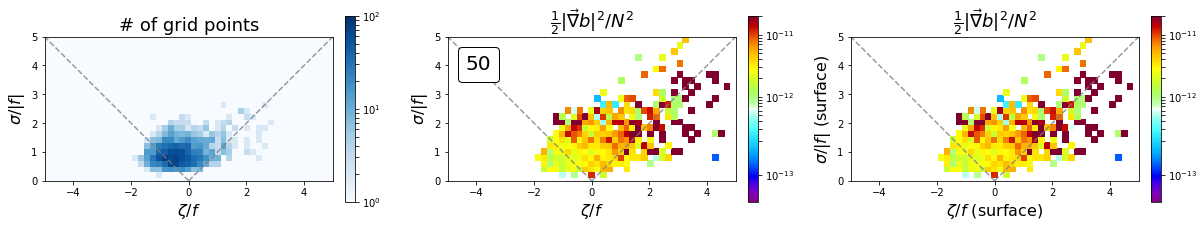

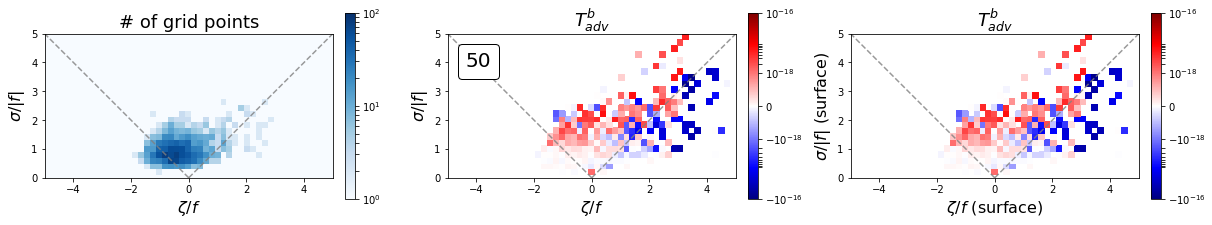

In [193]:

ibin=0;
data='adcp75avg'


cond = dxbuoy2_avg_75[ibin]>1e-14 # only surface frontal regions
cond=np.isfinite(M_avg_75[ibin])

jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],div_avg_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_75[0],strainsfc=strain_avg_75[0], levels=np.arange(-1.,1.02,0.02)*10.,\
         varname='div',cond= cond) #,cond=np.isfinite(dxbuoy2_avg_75[ibin]))

jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],dxbuoy2_avg_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_75[0],strainsfc=strain_avg_75[0],varname='dxbuoy2', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*5e-14,cond= cond)

jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],M_avg_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_75[0],strainsfc=strain_avg_75[0],varname='M', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*2e-11,cond= cond)

jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],tend_avg_75[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_avg_75[0],strainsfc=strain_avg_75[0],\
         varname='tendency',  cmap = 'blue_red', levels=np.arange(-1.,1.02,0.02)*1e-16,cond= cond)



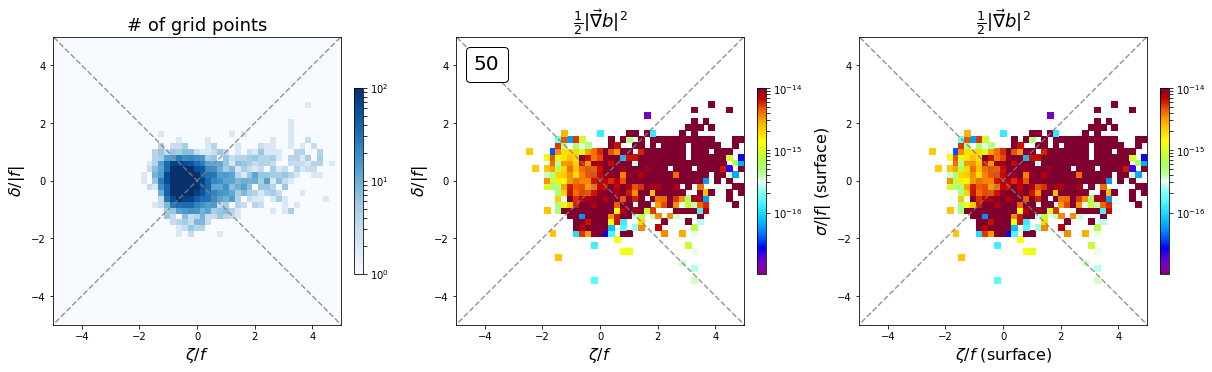

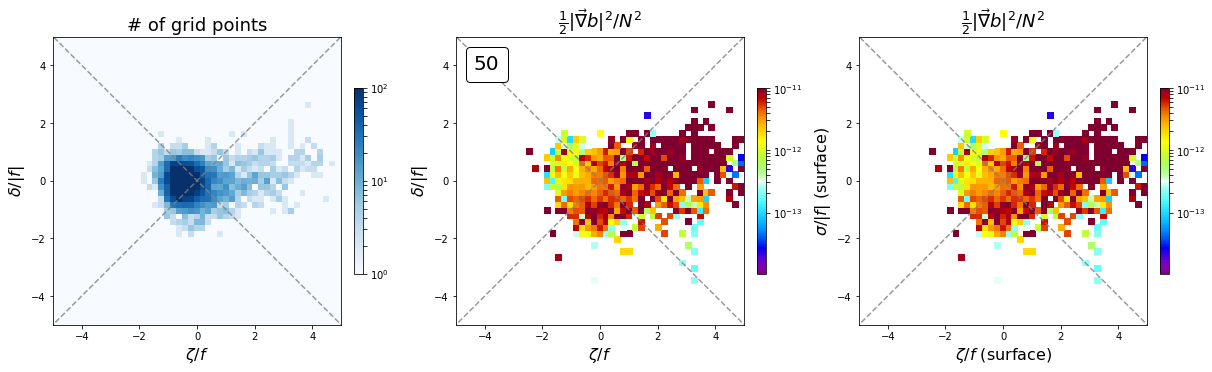

In [194]:
ibin=0;

cond=np.isfinite(M_bin[ibin])

jpdf(vrt_bin[ibin],div_bin[ibin],dxbuoy2_bin[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin[0],strainsfc=div_bin[0],varname='dxbuoy2',cond=cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-14,symstrain=False)

jpdf(vrt_bin[ibin],div_bin[ibin],M_bin[ibin],format(zbin[ibin+1]),data=data,\
         vrtsfc=vrt_bin[0],strainsfc=div_bin[0],varname='M',cond=cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-11,symstrain=False)


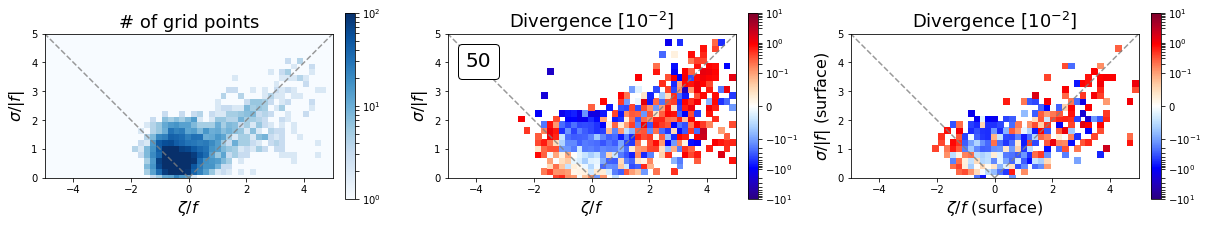

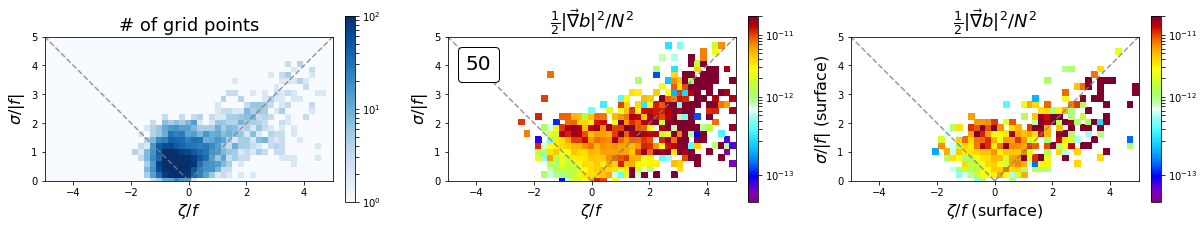

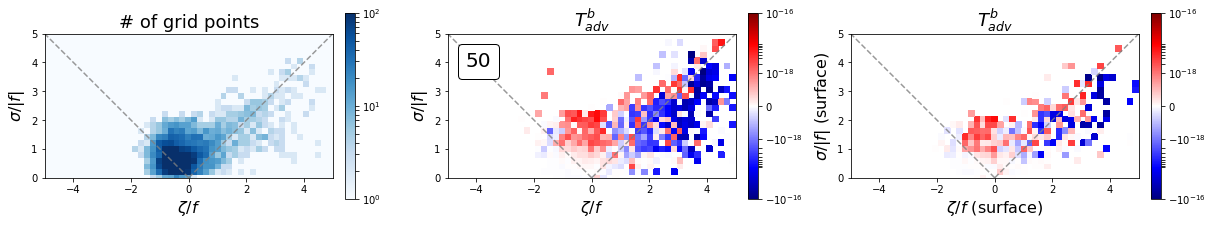

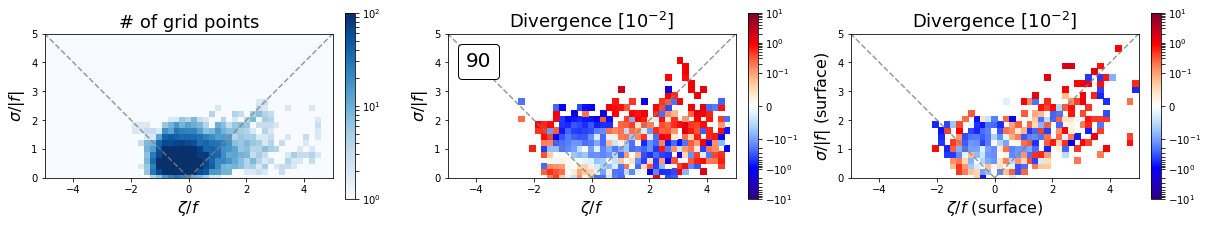

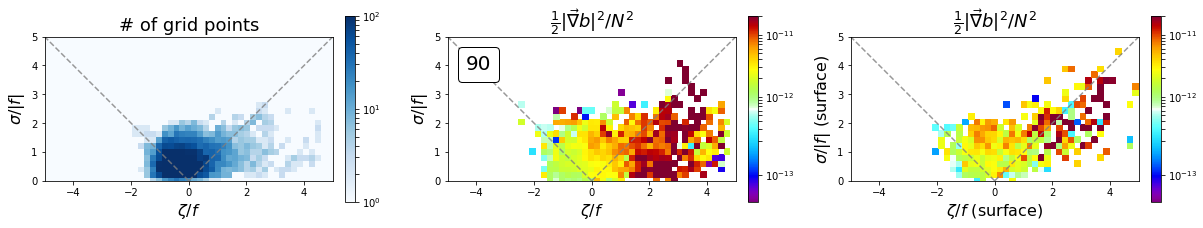

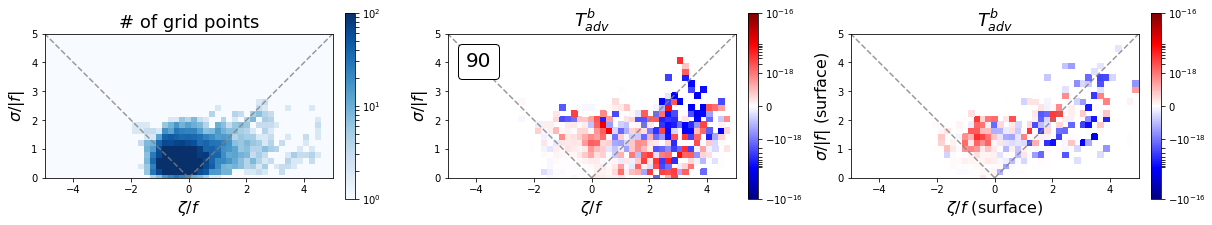

In [195]:
data='adcp300bin'


for ibin in range(len(zbin_300[1:])):
    
    cond = dxbuoy2_bin_surf_300[ibin]>10e-14 # only surface frontal regions
    
    cond = np.isfinite(M_bin_300[ibin])

    '''
    cond =  functools.reduce( np.logical_and, (\
                             vrt_bin_surf_300[ibin]>0.,
                             strain_bin_surf_300[ibin]>vrt_bin_surf_300[ibin],\
                             div_bin_surf_300[ibin]<0.,                
                             np.isfinite(M_bin_300[ibin])
                            ))
    '''
    
    jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],div_bin_300[ibin],format(zbin_300[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin], levels=np.arange(-1.,1.02,0.02)*10.,\
         varname='div',cond= cond)
    
    '''jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],dxbuoy2_bin_300[ibin],format(zbin_300[ibin+1]),\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin],varname='dxbuoy2',cond= cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-13)'''

    
    jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],M_bin_300[ibin],format(zbin_300[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin],varname='M', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*2e-11,cond= cond)
    
    jpdf(vrt_bin_300[ibin],strain_bin_300[ibin],tend_bin_300[ibin],format(zbin_300[ibin+1]),data=data,\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=strain_bin_surf_300[ibin],\
         varname='tendency', cmap = 'blue_red', levels=np.arange(-1.,1.02,0.02)*1e-16,cond= cond)

    
    '''jpdf(vrt_bin_300[ibin],div_bin_300[ibin],dxbuoy2_bin_300[ibin],format(zbin_300[ibin+1]),\
         vrtsfc=vrt_bin_surf_300[ibin],strainsfc=div_bin_surf_300[ibin],varname='dxbuoy2',cond= cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-13,symstrain=False)'''
    
    

    

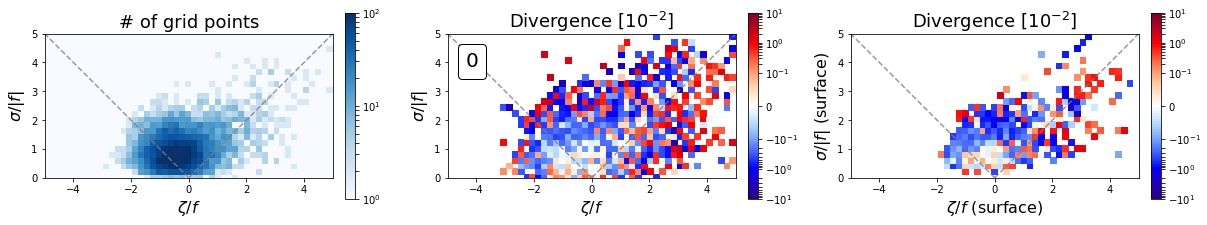

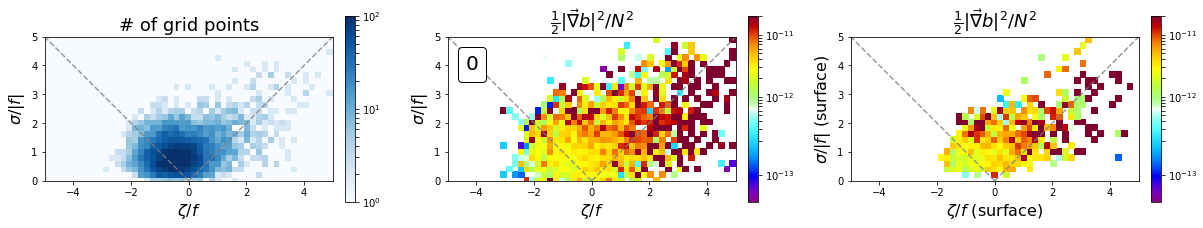

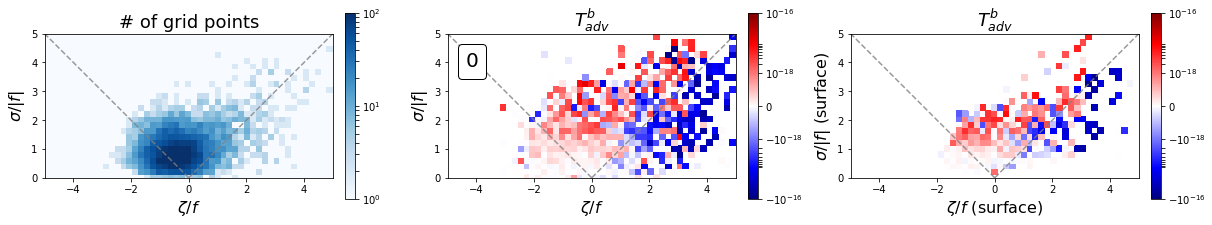

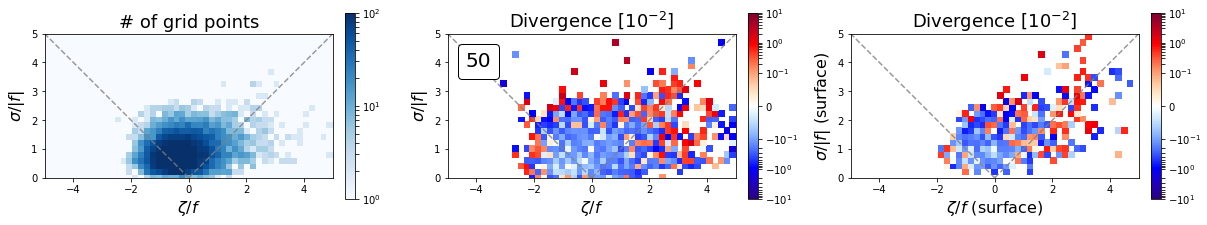

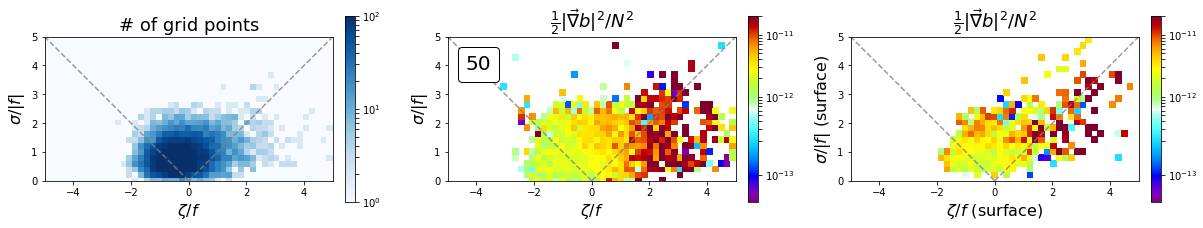

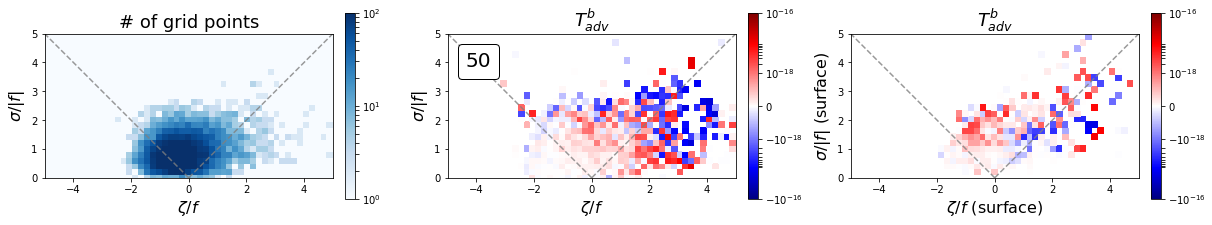

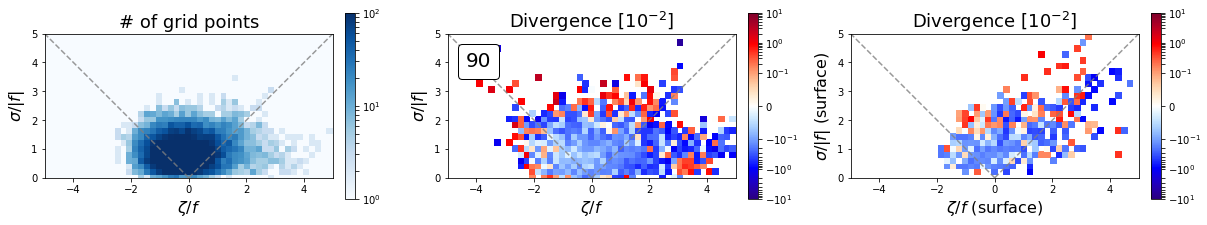

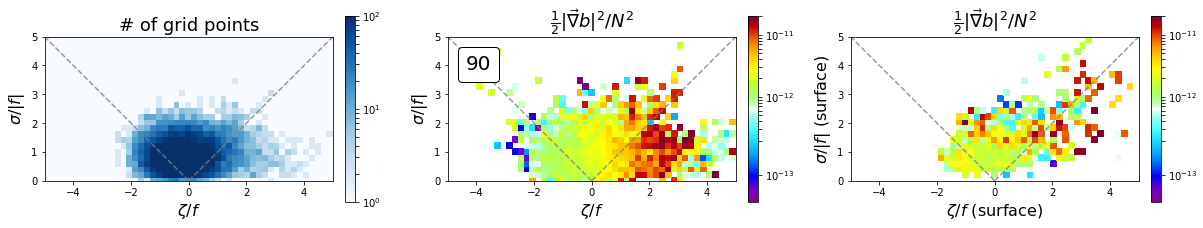

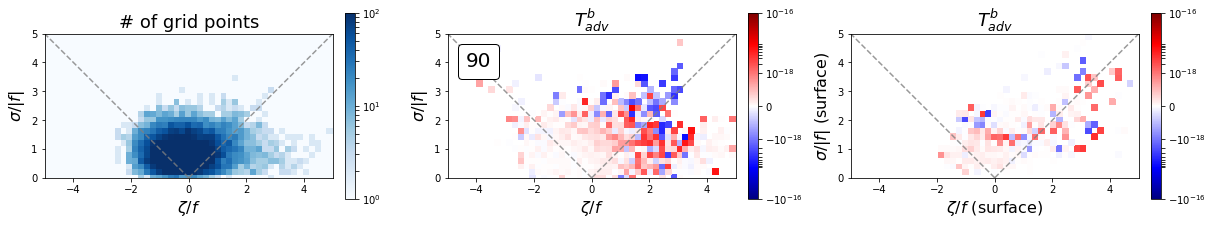

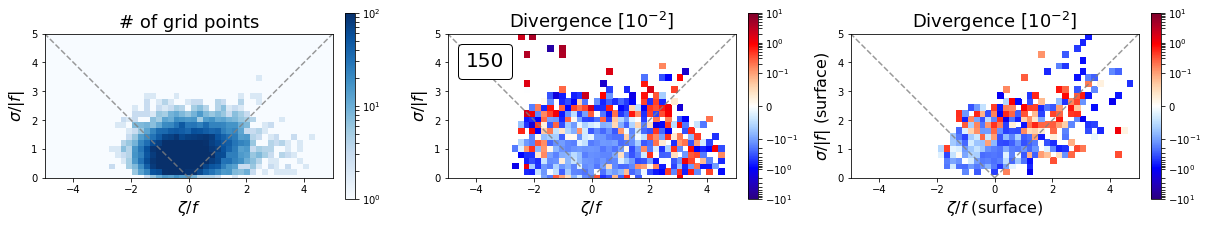

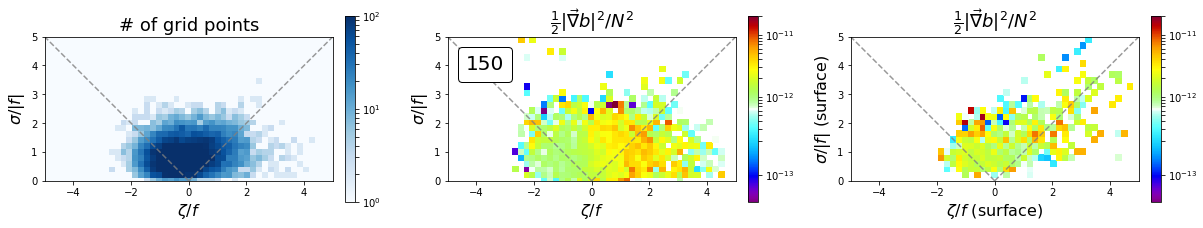

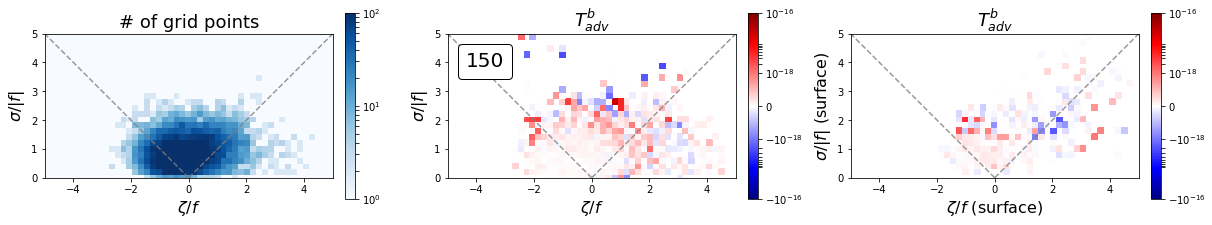

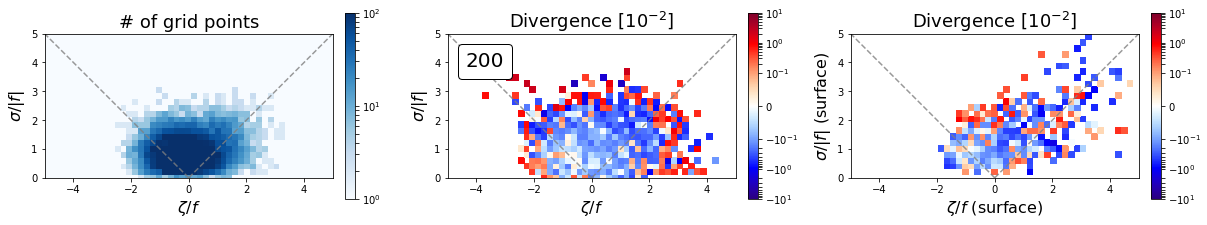

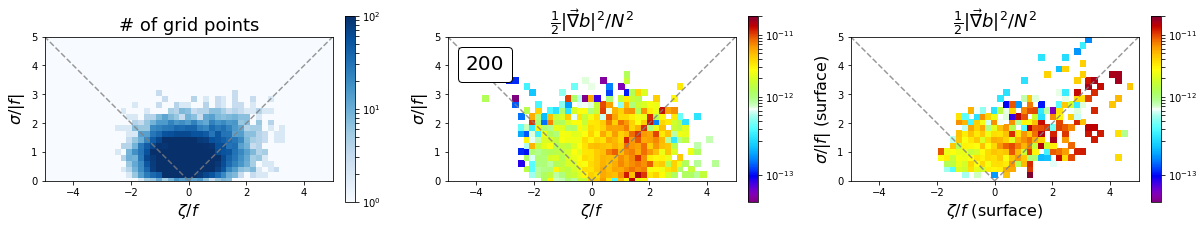

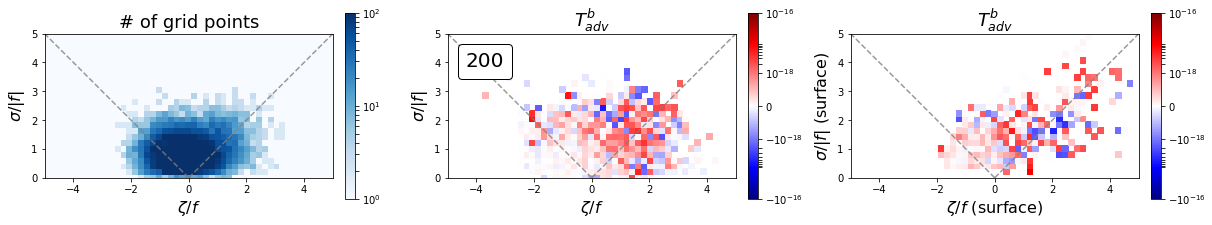

In [196]:
data='adcp75bin'


for ibin in range(len(zbin_75[1:])):
    
    cond = dxbuoy2_bin_surf_75[ibin]>10e-14 # only surface frontal regions
    
    cond = np.isfinite(M_bin_75[ibin])

    '''
    cond =  functools.reduce( np.logical_and, (\
                             vrt_bin_surf_75[ibin]>0.,
                             strain_bin_surf_75[ibin]>vrt_bin_surf_75[ibin],\
                             div_bin_surf_75[ibin]<0.,                
                             np.isfinite(M_bin_75[ibin])
                            ))
    '''
    
    jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],div_bin_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin], levels=np.arange(-1.,1.02,0.02)*10.,\
         varname='div',cond= cond)
    
    '''jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],dxbuoy2_bin_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin],varname='dxbuoy2',cond= cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-13)'''

    
    jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],M_bin_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin],varname='M', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*2e-11,cond= cond)
    
    jpdf(vrt_bin_75[ibin],strain_bin_75[ibin],tend_bin_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=strain_bin_surf_75[ibin],\
         varname='tendency', cmap = 'blue_red', levels=np.arange(-1.,1.02,0.02)*1e-16,cond= cond)

    
    '''jpdf(vrt_bin_75[ibin],div_bin_75[ibin],dxbuoy2_bin_75[ibin],format(zbin_75[ibin]),\
         vrtsfc=vrt_bin_surf_75[ibin],strainsfc=div_bin_surf_75[ibin],varname='dxbuoy2',cond= cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-13,symstrain=False)'''
    
    

    

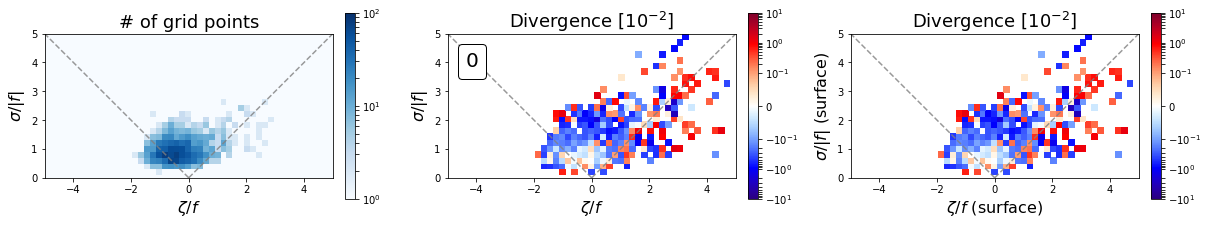

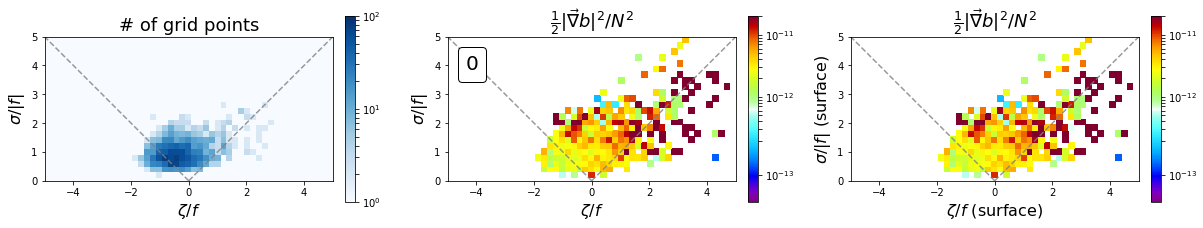

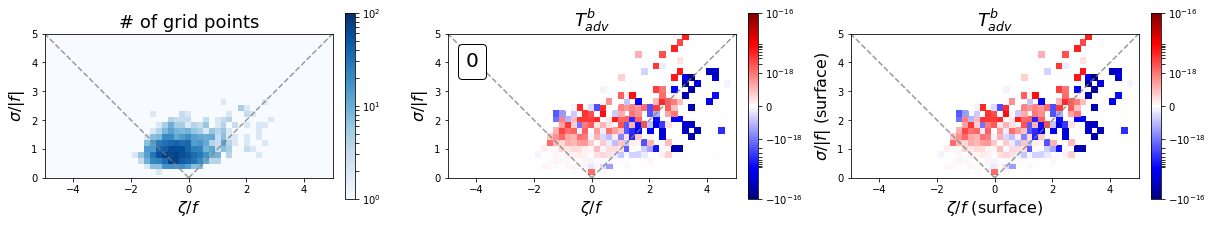

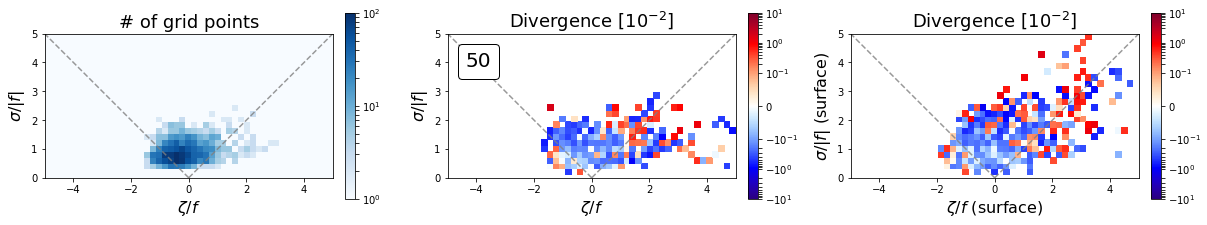

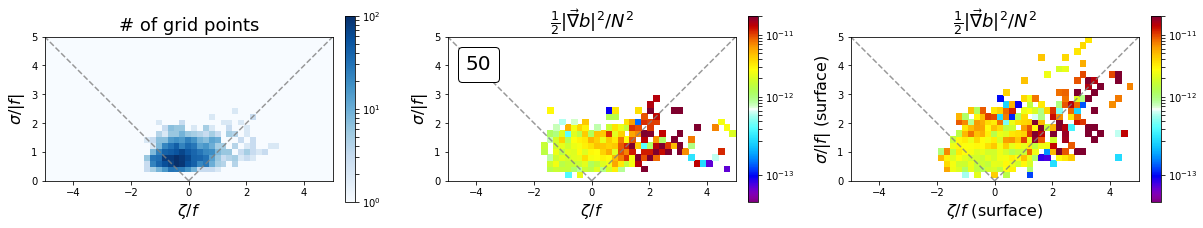

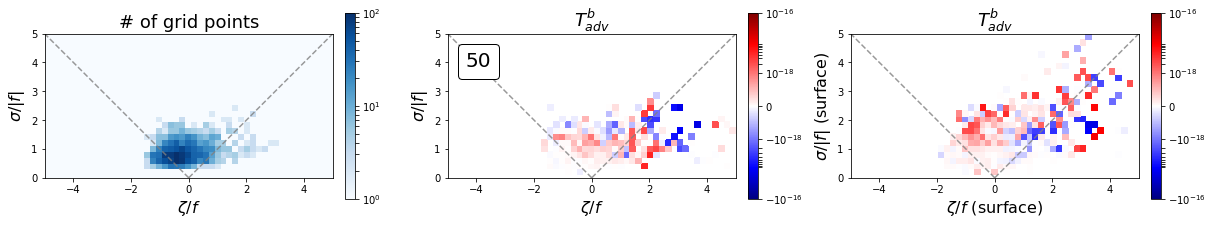

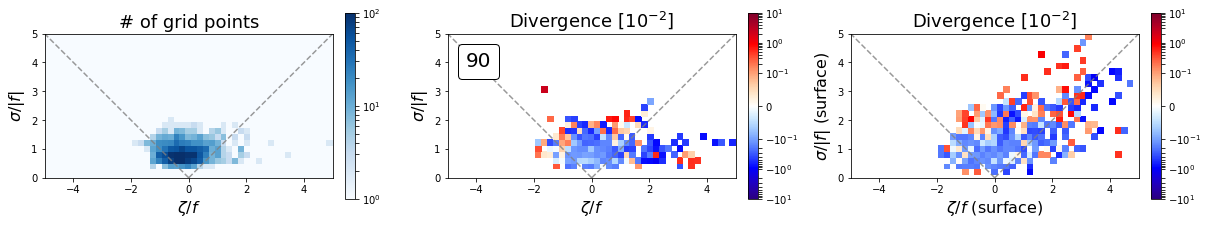

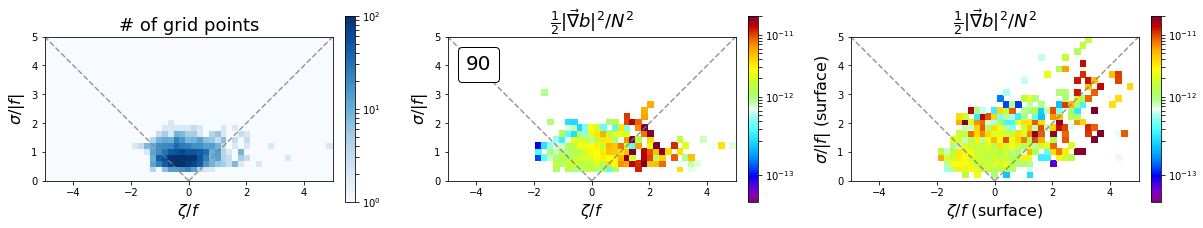

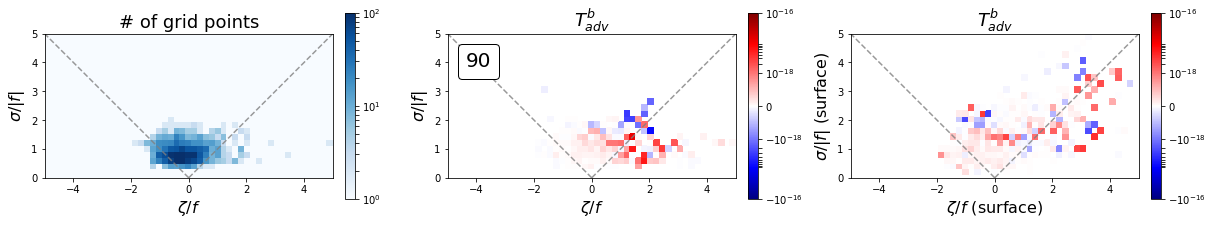

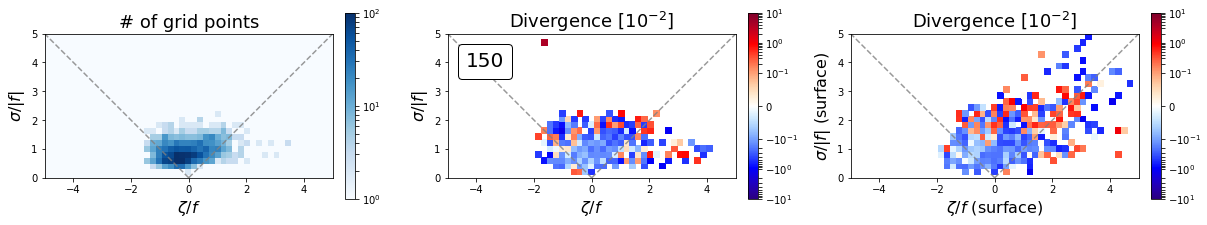

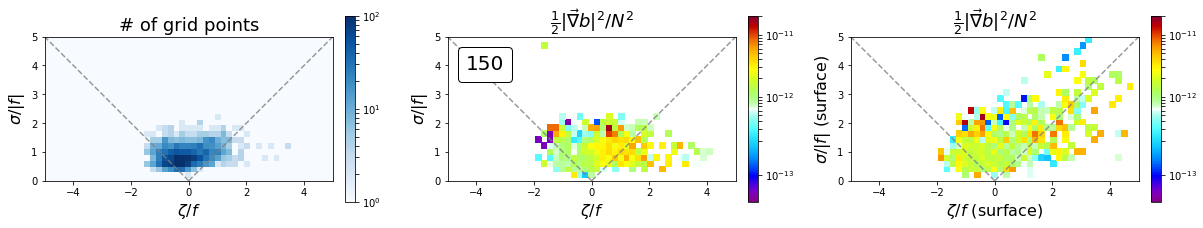

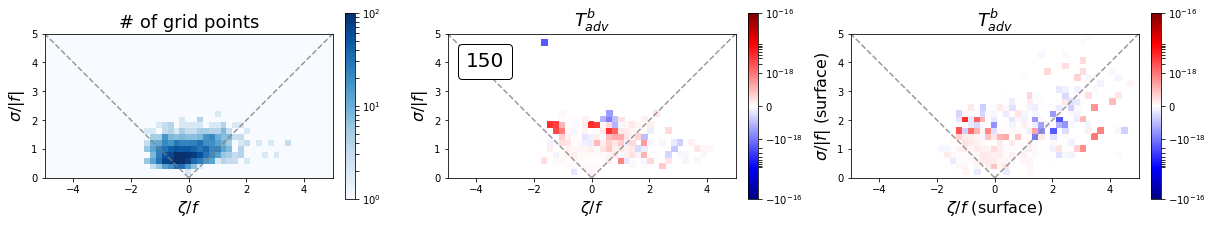

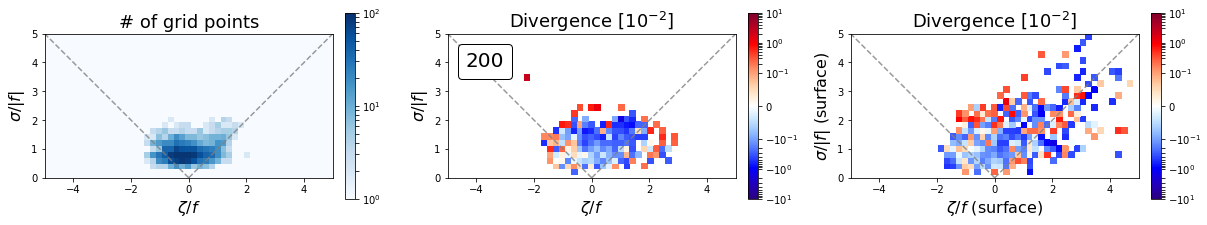

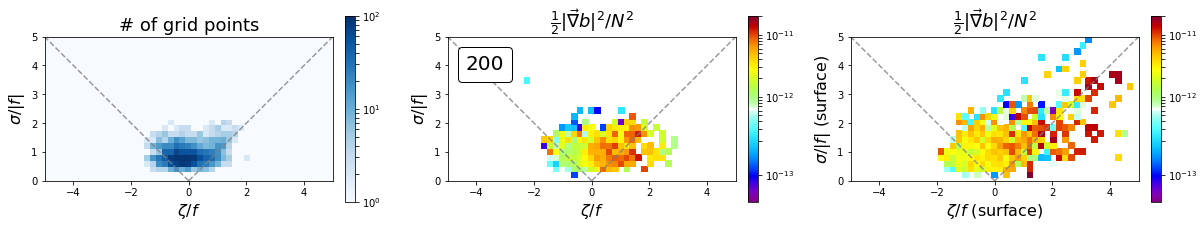

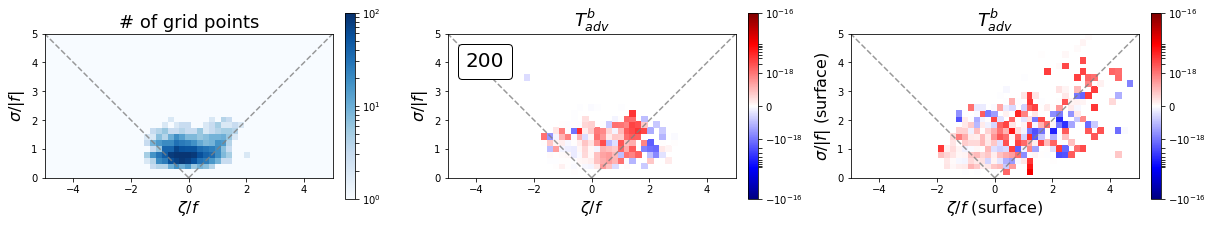

In [197]:
data='adcp75avg'


for ibin in range(len(zbin_75[1:])):
    
    cond = dxbuoy2_avg_75[ibin]>10e-14 # only surface frontal regions
    
    cond = np.isfinite(M_avg_75[ibin])

    '''
    cond =  functools.reduce( np.logical_and, (\
                             vrt_avg_75[ibin]>0.,
                             strain_avg_75[ibin]>vrt_avg_75[ibin],\
                             div_avg_75[ibin]<0.,                
                             np.isfinite(M_avg_75[ibin])
                            ))
    '''
    
    jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],div_avg_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_avg_75[0],strainsfc=strain_avg_75[0], levels=np.arange(-1.,1.02,0.02)*10.,\
         varname='div',cond= cond)
    
    '''jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],dxbuoy2_avg_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_avg_75[ibin],strainsfc=strain_avg_75[ibin],varname='dxbuoy2',cond= cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-13)'''

    
    jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],M_avg_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_avg_75[0],strainsfc=strain_avg_75[0],varname='M', \
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*2e-11,cond= cond)
    
    jpdf(vrt_avg_75[ibin],strain_avg_75[ibin],tend_avg_75[ibin],format(zbin_75[ibin]),data=data,\
         vrtsfc=vrt_avg_75[0],strainsfc=strain_avg_75[0],\
         varname='tendency', cmap = 'blue_red', levels=np.arange(-1.,1.02,0.02)*1e-16,cond= cond)

    
    '''jpdf(vrt_avg_75[ibin],div_avg_75[ibin],dxbuoy2_avg_75[ibin],format(zbin_75[ibin]),\
         vrtsfc=vrt_avg_75[ibin],strainsfc=div_avg_75[ibin],varname='dxbuoy2',cond= cond,\
         cmap = 'jaisnb', levels=np.arange(0.001,1.02,0.005)*1e-13,symstrain=False)'''
    
    

    

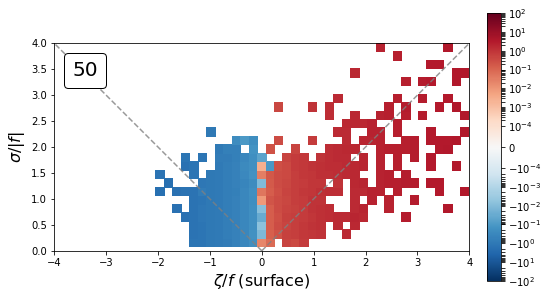

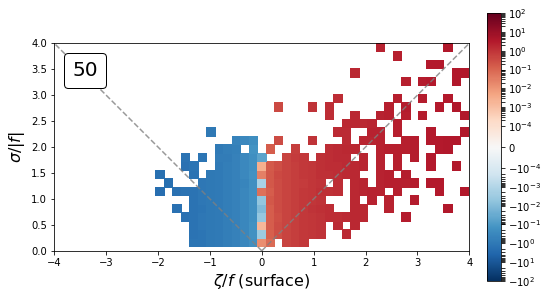

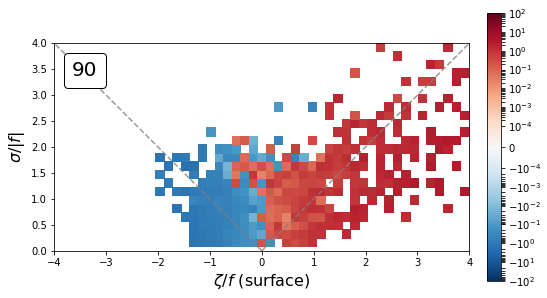

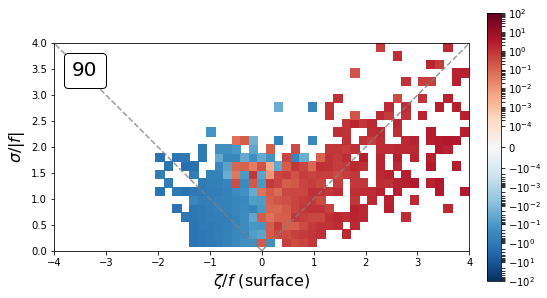

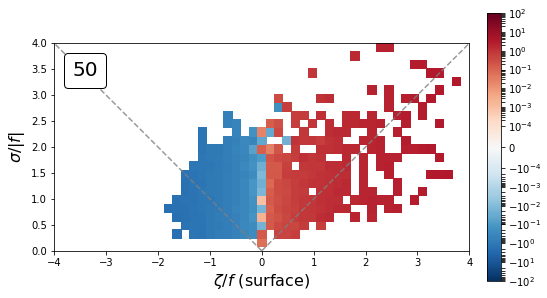

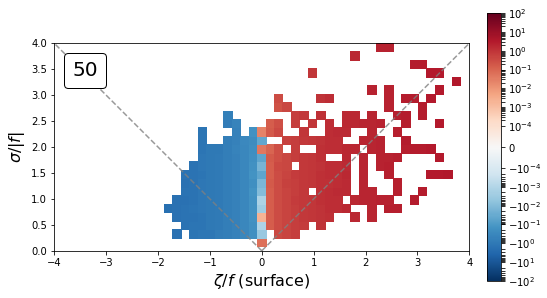

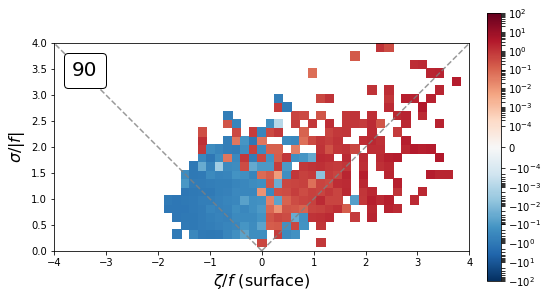

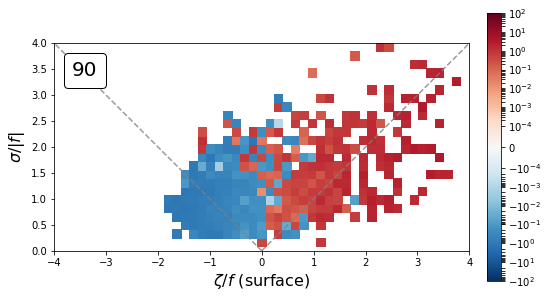

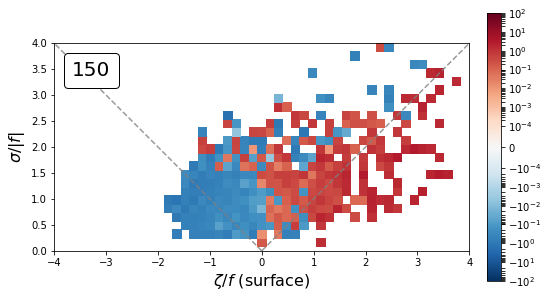

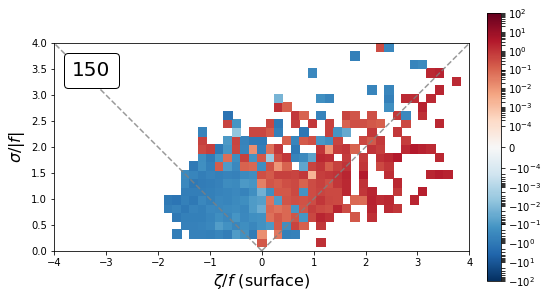

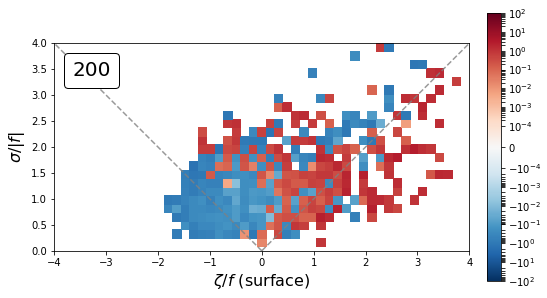

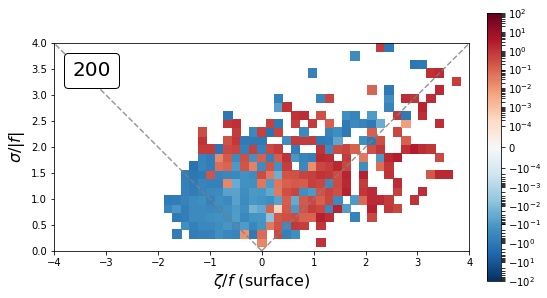

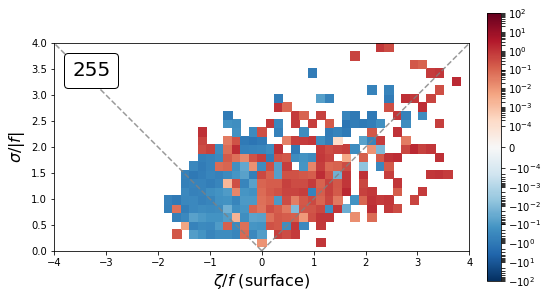

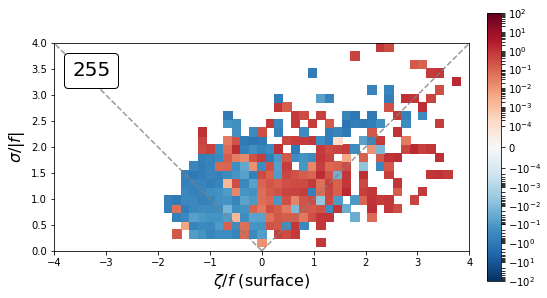

In [185]:



def jpdf_vrt(vrtsfc,strainsfc,vrt,label,varname='vrt',cond=True,symstrain=True):
    
    
    xlim_ref = 4; bins_ = np.linspace(-xlim_ref,xlim_ref,50)
            
    if symstrain: 
        sample_points_identity = np.arange(0,10,0.1)
    else:
        sample_points_identity = np.arange(-10,10,0.1)
        
    ##########
    f,axe = plt.subplots(1,1,figsize=(8,6)) #,facecolor='Gainsboro') #, constrained_layout=True)

    
    #axe = axes[0]
    axe.plot(sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
    axe.plot(-sample_points_identity, sample_points_identity, '--', c = 'gray', alpha = 0.8)
    axe.set_xlim((-1.*xlim_ref,1.*xlim_ref)) ; 
    axe.set_xlabel(r'$\zeta/f$',fontsize=16); 

            
    ####################
    ## 
    vrt_vrt_strain, xedges, yedges,_ = st.binned_statistic_2d(vrtsfc[cond].ravel(),strainsfc[cond].ravel(),\
                                                              values=vrt[cond].ravel(),\
                                                        statistic='mean', bins = bins_)


    # Plot 2D histogram using pcolormesh
    im = axe.pcolormesh(xedges,yedges,ma.masked_invalid(vrt_vrt_strain.T),cmap='RdBu_r',\
                        norm=colors.SymLogNorm(linthresh=1e-4,base=10,vmin=-100,vmax=100))
    f.colorbar(im, ax = axe,fraction=0.03, pad=0.04)
    
    if varname=='vrt':
        varlabel = r'$\zeta/f$ (surface)'
    elif varname=='div':
        varlabel = 'Divergence [10$^{-2}$]'
        
    #axe.set_title('Relative vorticity',fontsize=18)
    axe.set_xlabel(varlabel,fontsize=16); 
    
    if symstrain: 
        axe.set_ylim((0,1.*xlim_ref)) ; axe.set_aspect('equal')
        axe.set_ylabel(r'$\sigma/|f|$',fontsize=16)
    else:
        axe.set_ylim((-1.*xlim_ref,1.*xlim_ref)) ; axe.set_aspect('equal')
        axe.set_ylabel(r'$\delta/|f|$',fontsize=16)

    # add label
    at = AnchoredText(label,loc=2, prop=dict(size=20), frameon=True, )
    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2"); axe.add_artist(at)
    
    plt.subplots_adjust(wspace=0.3)
    
    ####################

###############################



for ibin in range(len(zbin_300[1:])):

    cond = np.isfinite(M_bin_300[ibin])
    jpdf_vrt(vrt_bin_surf_300[ibin],strain_bin_surf_300[ibin],vrt_bin_300[ibin],format(zbin_300[ibin+1]),cond=cond)
    cond = np.isfinite(M_avg_300[ibin])
    jpdf_vrt(vrt_avg_300[0],strain_avg_300[0],vrt_avg_300[ibin],format(zbin_300[ibin+1]),cond=cond)

    

    
for ibin in range(len(zbin_75[1:])):
    
    cond = np.isfinite(M_bin_75[ibin]) 
    jpdf_vrt(vrt_bin_surf_75[ibin],strain_bin_surf_75[ibin],vrt_bin_75[ibin],format(zbin_75[ibin+1]),cond=cond)
    cond = np.isfinite(M_avg_75[ibin])
    jpdf_vrt(vrt_avg_75[0],strain_avg_75[0],vrt_avg_75[ibin],format(zbin_75[ibin+1]),cond=cond)

    
    
    

KeyError: 2

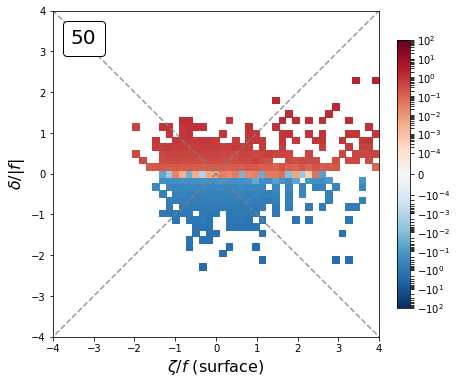

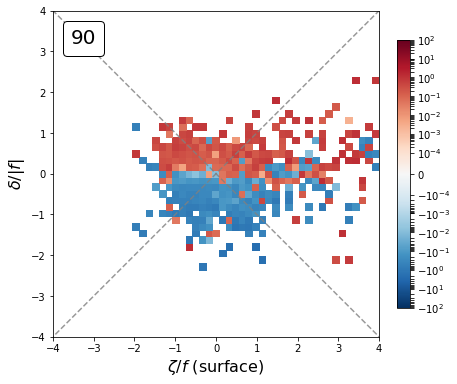

In [186]:

for ibin in range(len(zbin)):

        
    cond = dxbuoy2_bin_surf[ibin]>0.1e-14 # only surface frontal regions
    cond = np.isfinite(M_bin[ibin])
    
        
    '''cond =  functools.reduce( np.logical_and, (\
                             vrt_bin_surf[ibin]>0.,
                             strain_bin_surf[ibin]>vrt_bin_surf[ibin],\
                             div_bin_surf[ibin]<0.,                
                             np.isfinite(dxbuoy2_bin[ibin])
                            ))'''
    
    jpdf_vrt(vrt_bin_surf[ibin],div_bin_surf[ibin],div_bin[ibin],format(zbin[ibin+1]),symstrain=False,cond=cond)
    
    
    